# Background

I studied reading time of sentences with indeclinable pseudonouns for the last year's coursework. 
Epxeriment was designed as classic self-paced reading task. All the nouns on the slide are masked with "---" first and subject subsequently reveals each item by pressing the button. After the button pressed the read words become masked again. The indeclinables had various gender agreement on past tensed verb following the noun (feminine, neuter or masculine). Before each task paricipants also read a "dictionary article" containing explanation of a give pseudo noun. These explanations contain a hypernym of a given noun. A hypernym was one of the grammatical genders. Potentially it could influence the anticipated gender as it works with real indeclinables (cf. *aven'u* is frequently feminine due to its semantic analogy *ulica*).

Three conditions were attested: gender of hypernyms, ending vowel of a pseudo noun (-*e*,-*o*,-*i*,-*u*,-*a*,) and agreement gender.

Example of the stimulus task:

*Article:*
***джорба́ — лиственное дерево, растущее в Амазонии. Под джорба часто спят ленивцы.***

*Task:*
***Из-за урагана джорба упало в быструю реку.***

We found that feminine hypernym accelerated the Reaction Time to feminine agreement.

# This experiment

We want to test whether similar hypernym priming effect is feasable for declinable pseudo nouns.
We used the same tasks but we rewrote the "articles" to contain declinable nouns and changed inventory of ending vowels of the nouns. First, we changed all -*u* and -*i* nouns to the nouns with soft consonant endings. Some consonants had femine declensions type like *kost'* while other had masculine declension sybtype like *gvozd'*.

Example of the stimulus task:
*Article:*
***джорба́ — лиственное дерево, растущее в Амазонии. Под джорбами часто спят ленивцы.***

*Task:*
***Из-за урагана джорба упало в быструю реку.***

In [181]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import clear_output
import statsmodels.formula.api as smf

In [182]:
#pip install -q pymer4
from pymer4.models import Lmer

Experiment preparations

First of all, I want to utilize Python to construct the stimuli in appropriate format for the Ibexfarm experiment platform. I planned my protocols in the .xlsx file, I also prepared some of the needed text format features but I want three ready to use text fragments.

In [183]:
protocol_1,protocol_2,protocol_3 = pd.read_excel("DECL_novel_words_stimuli.xlsx"),pd.read_excel("DECL_novel_words_stimuli.xlsx",sheet_name=1),pd.read_excel("DECL_novel_words_stimuli.xlsx",sheet_name=2)

In [184]:
protocol_1.head(3)

,Номер тройки,Финаль,Ударение на финали,Согласный перед финалью,Гипероним_род,Глагол_род,Словарная статья,Чтение,Вопрос по содержанию,Вопрос по словарной статье,...,id стимула,Unnamed: 12,Длина чтения,Unnamed: 14,Unnamed: 15,ibex_item,Unnamed: 17,Unnamed: 18,Unnamed: 19,СЛЧИС
0,25,Cjf,0,ч,ж,м,<center>фабе́дь — китайская ваза для благовони...,По праздникам фабедь наполнял залы сладким дымом.,NaN,NaN,...,Cjf_hf_vm,NaN,49,NaN,NaN,"['Cjf_hf_vm', 'Message', {html: '<center>фабе́...",NaN,NaN,NaN,0.300211
1,5,а,0,л,с,ж,<center>ки́нла — деревянное судно коренных жит...,Каждую весну кинла плыла вдоль заснеженного по...,Вдоль чего плыла кинла? а) побережья б) реки,NaN,...,a_hn_vf,NaN,54,NaN,NaN,"['a_hn_vf', 'Message', {html: '<center>ки́нла ...",NaN,NaN,NaN,0.001320
2,20,Cjm,0,д,ж,с,"<center>фо́лень — токсичная туча, содержащая ч...",Из-за ветра фолень нависло над мэрией города.,NaN,NaN,...,Cjm_hf_vn,NaN,45,NaN,NaN,"['Cjm_hf_vn', 'Message', {html: '<center>фо́ле...",NaN,NaN,NaN,0.662491


Sample of the string we want (ibex farm is powered with JavaScript):

["a_hn_vf", "Message", {html: "\<center>ки́нла — деревянное судно коренных жителей Канады.\<br> В кинла хватает места для отряда охотников.\</center>"}, "DashedSentence", {s: "Каждую весну кинла плыла вдоль заснеженного побережья."}, "Question", {q:"Вдоль чего плыла кинла?", as:["побережья","реки"], hasCorrect:"побережья"}],


In [185]:
def get_protocol(data, file):
    full_items = []
    for _id_, article, reading, q_cont, q_article, cor_answer in zip(data["id стимула"],data["Словарная статья"],data["Чтение"],
                                                                     data["Вопрос по содержанию"],data["Вопрос по словарной статье"], data["Правильный вариант ответа"]):
        if pd.isnull(cor_answer): # If there is no control question for the item
            item = [f"[\'{_id_}\',","\'Message\',", f"{{html: \'{article}\'}},",
                f"\'DashedSentence\',", f"{{s: \'{reading}\'}}],"]
            item = " ".join(item)
        if pd.notnull(q_cont): # If there IS control question for the item based on CONTENT
            answ_options = q_cont.split("? а) ")[1].split(" б) ")
            q_cont = q_cont.split("? а) ")[0] + "?"
            item = [f"[\'{_id_}\',","\'Message\',", f"{{html: \'{article}\'}},",
                    f"\'DashedSentence\',", f"{{s: \'{reading}\'}},",
                    "\'Question\',",  f"{{q: \'{q_cont}\', as:{answ_options}, \'hasCorrect\': \'{cor_answer}\'}}],"]
            item = " ".join(item)
        if pd.notnull(q_article): # If there IS control question for the item based on CONTENT
            answ_options = q_article.split("? а) ")[1].split(" б) ")
            q_cont = q_article.split("? а) ")[0] + "?"
            item = [f"[\'{_id_}\',","\'Message\',", f"{{html: \'{article}\'}},",
                    f"\'DashedSentence\',", f"{{s: \'{reading}\'}},",
                    "\'Question\',",  f"{{q: \'{q_article}\', as:{answ_options}, \'hasCorrect\': \'{cor_answer}\'}}],"]
            item = " ".join(item)

        full_items.append(item)

    full_items[-1] = full_items[-1].replace("}],", "}]") # delete last comma in the formated text
    with open(file, "w") as fp:
        for item in full_items:
            item.replace("  "," ") #eliminate accidental double spaces
            fp.write("%s\n" % item)

In [186]:
# we have three protocols and I want to have them in a convenient .txt format with transeperent names
i = 1
for datasheet in [protocol_1,protocol_2,protocol_3]:
    get_protocol(datasheet, f"protocol{i}.txt")
    i +=1

# The next steps are conducted after I used the code above to collect the data

In [187]:
# DOWNLOAD DATA SHEETS
# and make 
files = os.listdir()
data = pd.DataFrame()
for file_name in files:
    if "results_" in file_name:
        temp = pd.read_table(file_name, comment = '#', header=None)
        data = pd.concat([data, temp])

In [188]:
## WRANGLE THE DATA TOWARDS THE ADEQUATE TABLE FORMAT

# Parse the data, put metadata, data on answering to attraction questions and data on reading the items into three different dictionaries
# parsing is based on a number of values separeted with commas are in the lines (luckily the number is different for meta-,question and reading data) 
intro_dic = {"Time_received":[],"Age":[],"Consent":[],"Sex":[],"Education":[],"_REACTION_TIME_":[]}

sentence_dic = {"Time_received":[], "hash":[], "Controller":[], "Item_number":[], "Element_number":[], "Type":[],"Group":[],"Word_number":[],"Word":[],"Reading_time":[],"Newline?":[],"Sentence":[]}
question_dic = {"Time_received":[], "hash":[], "Controller":[], "Item_number":[], "Element_number":[], "Type":[],"Group":[], "Question":[],"Answer":[],"Answer_is_correct":[],"Answer_time":[]}


for i in range(len(data)):
    if len(data.iloc[i,0].split(",")) == 9:
        x = data.iloc[i,0].split(",")
        intro_dic["Time_received"].append(x[0]) if x[0] not in intro_dic["Time_received"] else intro_dic["Time_received"] # registred time will be a primary key connecting various data of the same person, it is needed to be uniqe
        if x[7] == "education":
            intro_dic["Education"].append(x[8])
        if x[7] == "age":
            intro_dic["Age"].append(x[8])
        if x[7] == "consent":
            intro_dic["Consent"].append(x[8])
        if x[7] == "sex":
            intro_dic["Sex"].append(x[8])
        if x[7] == "_REACTION_TIME_":
            intro_dic["_REACTION_TIME_"].append(x[8])
    if len(data.iloc[i,0].split(",")) == 12:
        x = data.iloc[i,0].split(",")
        sentence_dic["Time_received"].append(x[0])
        sentence_dic["hash"].append(x[1])
        sentence_dic["Controller"].append(x[2])
        sentence_dic["Item_number"].append(x[3])
        sentence_dic["Element_number"].append(x[4])
        sentence_dic["Type"].append(x[5])
        sentence_dic["Group"].append(x[6])
        sentence_dic["Word_number"].append(x[7])
        sentence_dic["Word"].append(x[8])
        sentence_dic["Reading_time"].append(x[9])
        sentence_dic["Newline?"].append(x[10])
        sentence_dic["Sentence"].append(x[11])
    if len(data.iloc[i,0].split(",")) == 11:
        x = data.iloc[i,0].split(",")
        question_dic["Time_received"].append(x[0])
        question_dic["hash"].append(x[1])
        question_dic["Controller"].append(x[2])
        question_dic["Item_number"].append(x[3])
        question_dic["Element_number"].append(x[4])
        question_dic["Type"].append(x[5])
        question_dic["Group"].append(x[6])
        question_dic["Question"].append(x[7])
        question_dic["Answer"].append(x[8])
        question_dic["Answer_is_correct"].append(x[9])
        question_dic["Answer_time"].append(x[10])

In [189]:
## UNITE THE DATA ON PARTICIPANTS AND THEIR EXPERIMENTAL RESULTS
# "Time_received" will serve as a participant id in this notebook
sentence_data = pd.DataFrame.from_dict(sentence_dic) #info on reaction time
intro_data = pd.DataFrame.from_dict(intro_dic) #demographic info on particopants
question_data = pd.DataFrame.from_dict(question_dic) #data on control questions

sentence_and_meta = intro_data.merge(sentence_data, on = "Time_received") #отдельно соединяем информацию об участнике с результатами чтения


 #отдельно соединяем информацию об участнике с результатами ответов на контрольные вопросы
question_and_meta = question_data.merge(intro_data, on = "Time_received")


all_data = sentence_and_meta.merge(question_and_meta, how = 'outer') #объединяем данные с ответами на вопросы и данными чтения (обе таблицы уже содержат мета данные)

In [190]:
# DATA PREPARING AND CLEANING (tables and values)
all_data = all_data[all_data.Word_number != "8"] #accidental space in one stimulus made an excessive reading word, delete it
all_data = all_data[~all_data.Type.str.contains("Training")] #delete training data
all_data = all_data.drop(labels = ["Consent","Group","Newline?","_REACTION_TIME_"],axis = 1) # _REACTION_TIME_ contains data on how fast the demographic poll was complete


all_data[["Reading_time", "Age","Answer_is_correct"]] = all_data[["Reading_time", "Age",
                                   "Answer_is_correct"]].apply(pd.to_numeric) # "Answer_is_correct" to numeric since it eases calculations of correct answers' quantity

# extract experimental item features from "Type"
all_data.Type = all_data.Type.str.lower() # originally capitalized letters standed for stress, but we want to neglect it in this study

separated_things = all_data.Type.str.split("_", expand=True)
separated_things = separated_things.rename(columns={0: "final", 1: "hypernym_gender", 2: "verb_gender"})
all_data = pd.concat([separated_things, all_data], axis = 1) 


In [191]:
print("We have", str(len(all_data.Time_received.unique())), "participants in the begining", sep = " ")

We have 83 participants in the begining


In [192]:
### CLEANING BASED ON CONTROL QUESTIONS
# there were 15 questions all the time
threshold = 13 # let's make the threshold of deleteing the participant completely
deleted_people = []
passed_people = []
participants_before = len(all_data.Time_received.unique())
for value, _id_ in zip(all_data.groupby("Time_received").agg("sum").Answer_is_correct, 
                       all_data.groupby("Time_received").agg("sum").Answer_is_correct.index):
    if value >= threshold:
        passed_people.append(_id_)
    else:
        deleted_people.append(_id_)

print(str(deleted_people), "list of people we deleted", sep = "--")
for participant in deleted_people:
    all_data = all_data[all_data.Time_received != participant]
print("participants before:", participants_before)
print("participants after:", len(all_data.Time_received.unique()))

['1670771352', '1670771658', '1670771890', '1670772012', '1670881497', '1670882215', '1670882576']--list of people we deleted
participants before: 83
participants after: 76


In [193]:
all_data = all_data[all_data.Controller != "Question"]

In [194]:
all_data.head(2) # that is how our data looks like

,final,hypernym_gender,verb_gender,Time_received,Age,Sex,Education,hash,Controller,Item_number,Element_number,Type,Word_number,Word,Reading_time,Sentence,Question,Answer,Answer_is_correct,Answer_time
21,cjf,hn,vn,1670881449,22,male,non_linguist,e278a68b3afc25b0f379d2bf68da9a44,DashedSentence,7,1,cjf_hn_vn,1,Довольно,472.0,Довольно долго гешадь натирало спину старому п...,NaN,NaN,NaN,NaN
22,cjf,hn,vn,1670881449,22,male,non_linguist,e278a68b3afc25b0f379d2bf68da9a44,DashedSentence,7,1,cjf_hn_vn,2,долго,296.0,Довольно долго гешадь натирало спину старому п...,NaN,NaN,NaN,NaN


In [195]:
#all_data.to_excel("data_decl_novel.xlsx")

# EXPERIMENTAL DATA CLEANING (clen the data according to self-paced experiments data cleaning conventions)
We want co clean out the outliers as we assume that participatns could be distracted at some point or they could accidentaly skip a word.

In [196]:
#First let's have a look how our 'dirty' data look like
all_data.Word_number = pd.to_numeric(all_data.Word_number)
fig = px.scatter(x=all_data.Word_number, y=all_data.Reading_time, 
                 facet_col = all_data.verb_gender, color=all_data.Time_received)
fig.add_hline(y=3000)
fig.show()
# it is dirty indeed! The horizontal line deisgnates 3000 milliseconds RT. Everything above it are considered as outliers left alone RT above 10000 milliseconds.
# Fortunately, we can see that uncanny slow responses are from one or two participant, so our data is still reliable

In [197]:
# First step is to drop everything that was read way too slow or too fast
# Afterwards we delete every reaction time that stands out of average time for ±2,5 standard deviations for each experiment condition.
#(Average time is grouped by region and stimulus features like ending, agreement gender and hypernym gender)


def remove_outliers(data, high_absolute, low_absolute):
    data = data.query("Reading_time < @high_absolute & Reading_time > @low_absolute")
    
    data['Type_and_region'] = data.Type + data.Word_number.astype(str)
    mean_table = data.groupby('Type_and_region').Reading_time.agg(['std','mean'])
    
    for time, type_and_region in zip(data.Reading_time, data.Type_and_region):
        if (time > mean_table.xs('mean',axis = 1).loc['cjf_hn_vn1'] + 2.5 * mean_table.xs('std',axis = 1).loc['cjf_hn_vn1'] or 
        time < mean_table.xs('mean',axis = 1).loc['cjf_hn_vn1'] - 2.5 * mean_table.xs('std',axis = 1).loc['cjf_hn_vn1']):
            data[data['Type_and_region'] == type_and_region] = data[data['Type_and_region'] == type_and_region
                                                                   ].query("Reading_time != @time")
    data = data.dropna(axis = 0, subset = "Reading_time")
    return data

In [198]:
%%capture --no-stdout
print("before cleaining outliers",len(all_data))
all_data = remove_outliers(all_data, 3000, 100)
print("after cleaining outliers", len(all_data))

before cleaining outliers 23940
after cleaining outliers 22628


In [199]:
# we also need to delete all participants for whom we lost more than 15% of the data
print("Number of participants before dropping: ", len(all_data.Time_received.unique()))
answers_total = len(all_data.Type_and_region.unique()) #how many words per protocol
threshold = round(answers_total *0.85)
print("The threshold: ", threshold)

to_delete_l = []
for remained_answers, _id_ in zip(all_data.groupby("Time_received").Type_and_region.count(),
                            all_data.groupby("Time_received").Type_and_region.count().index):
    if len(all_data[all_data.Time_received == _id_]) < threshold: #count how many answers 
        to_delete_l.append(_id_)
print("Delete these ", len(to_delete_l)," participants: ", to_delete_l)

all_data = all_data[~all_data["Time_received"].isin(to_delete_l)]

print("Number of remained data points: ", len(all_data))
print("Number of remained participants: ", len(all_data.Time_received.unique()))

Number of participants before dropping:  76
The threshold:  268
Delete these  7  participants:  ['1670773784', '1670882166', '1670882399', '1670882417', '1670882458', '1670883069', '1670884535']
Number of remained data points:  21069
Number of remained participants:  69


In [200]:
#Let's have a llok at the same graph with the cleaned data
all_data.Word_number = pd.to_numeric(all_data.Word_number)
fig = px.scatter(x=all_data.Word_number, y=all_data.Reading_time, 
                 facet_col = all_data.verb_gender, color=all_data.Time_received)
fig.show()
# all the reaction time now lays between 100 and 1000 ms

# MANUAL CONTROL INSTRUMENT (trying to catch subjects who did not pay attention to the agreement at all)
Idea: I want to manually find if a participant was not paying attention to the strange agreement patterns in the stimuli. The experiments were posed on Toloka and we had unpleasent experience with tolokers in other sorts of experiments, that is why we should double check them.

In order to do this I will create a linegraph for each participant illustrating  reading time of obviously atypical agreement patterns. By that I mean examples like feminine agreement of declinable nouns with -*o* and -*e* endings. I will also compare it to mean reaction time to expected agreement examples like feminine agreement with -*a* nouns. 

In [201]:
i = 0
strange_l = ['cjf_hf_vn', 'a_hf_vn', 'o_hf_vm', 'e_hn_vf']
anticipated_l = ["a_hf_vf", 'o_hn_vn', 'e_hn_vn']
l = []
for tip in all_data.Type:
    if tip in strange_l:
        l.append("strange")
    elif tip in anticipated_l:
        l.append("anticipated")
    else:
        l.append("_")
all_data["strangeness"] = l


participants = all_data.Time_received.unique()
for participant in participants:
    i += 1
    df_temp = all_data[all_data["Time_received"] == participant]    
    df_temp = df_temp[df_temp["Type"].isin(strange_l+anticipated_l)]
    fig = px.line(df_temp, x="Word_number", y="Reading_time", title= str(participant),
                  color = "Type", line_dash = "strangeness")
    if input() != "stop": # WRITE "stop" to stop the slideshow
        clear_output(wait=True)
        fig.show()
        print("Reminder: 3rd region - pseudonoun, 4th - agreed verb, 5,6 - other nouns, 7 - the last noun, usually people make a considerable pause there")
        print("Write 'stop' to stop the slideshow")
        print(participant)
        print("Pariticpant №" + str(i))
    else:
        break

stop


# CLEANER DATA VIZUALIZATION

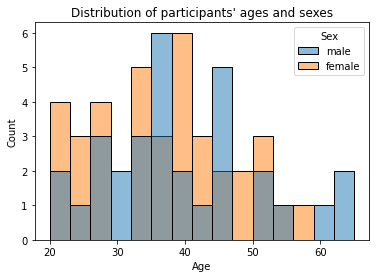

In [202]:
sns.histplot(all_data.query("Age < 150").drop_duplicates(subset = ["Time_received"]
                                 ), x="Age",binwidth=3, hue = "Sex"
            ).set(title="Distribution of participants' ages and sexes");


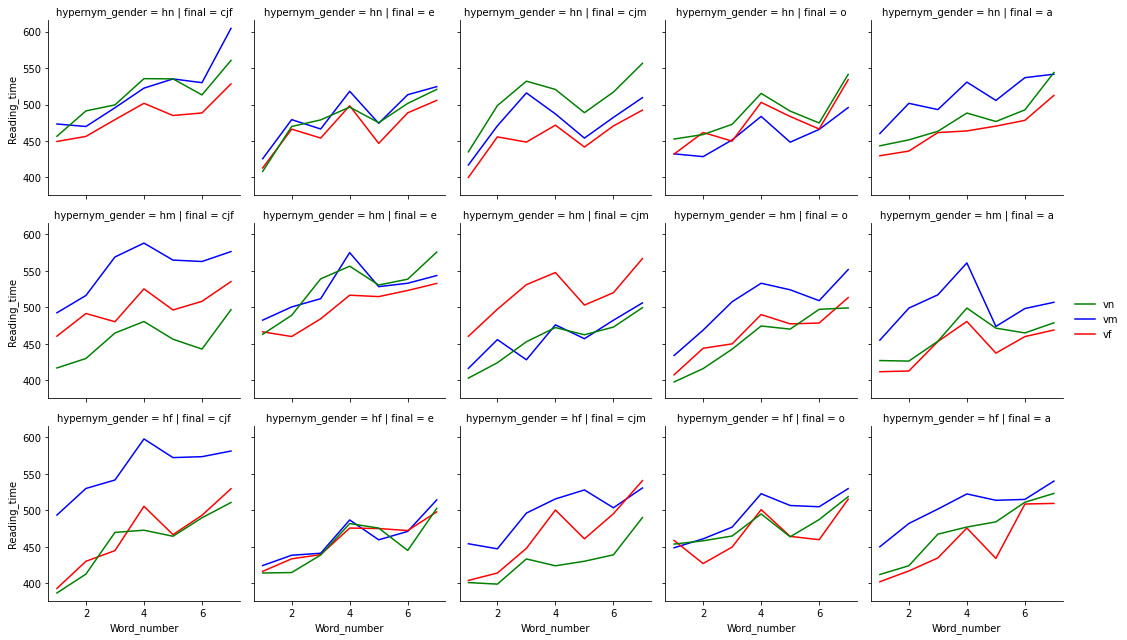

In [203]:
# let's make an overall plot that gives information about mean RT for every experimental condition
facet = sns.FacetGrid(all_data, col="final", row = "hypernym_gender");
facet.map_dataframe(sns.lineplot, "Word_number","Reading_time",
                    hue = "verb_gender", palette = ['blue','red','green'],
                   estimator='mean', ci = None);
facet.add_legend();
# il looks like we did not detect all outliers:
# look at the left lower corner of the facet, for instance. 
# at least at first two reading regions the time should be the same in stimuli with every gender agremeent
# since participants did not see the pseudo noun or agreement yet

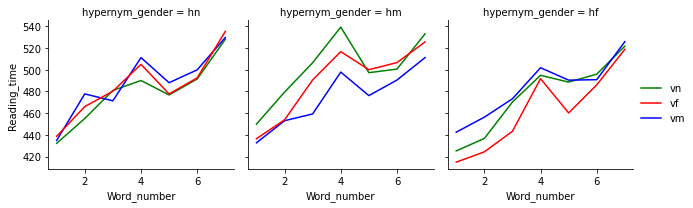

In [204]:
facet = sns.FacetGrid(all_data, col="hypernym_gender");
facet.map_dataframe(sns.lineplot, "Word_number","Reading_time",
                    hue = "verb_gender", palette = ['green','blue','red'],
                   estimator='mean', ci = None);
facet.add_legend();
# assessing it vizually it looks like the gender of hypernym can ease the reading of the stimuli

# MIXED EFFECT MODEL

In [205]:
### I realy tried statsmodel solution but I did not manage to work it properly
# in particular I did not made if look at the participant id as a second random effect group
#md = smf.mixedlm("Reading_time ~ hypernym_gender*verb_gender", all_data
 #                , groups=all_data["Item_number"])
#mdf = md.fit(method=["lbfgs"])
#print(mdf.summary())

In [206]:
# That is why I tried  R's lme4 adaptation in Pythpn
model = Lmer('Reading_time ~ hypernym_gender*verb_gender  + (1|Time_received) + (1|Item_number)', data=all_data)
display(model.fit())


/Users/Kirill/.local/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning:

Error while trying to convert the column "Question". Fall back to string conversion. The error is: <class 'float'>

/Users/Kirill/.local/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning:

Error while trying to convert the column "Answer". Fall back to string conversion. The error is: <class 'float'>

/Users/Kirill/.local/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning:

Error while trying to convert the column "Answer_time". Fall back to string conversion. The error is: <class 'float'>



Linear mixed model fit by REML [’lmerMod’]
Formula: Reading_time~hypernym_gender*verb_gender+(1|Time_received)+(1|Item_number)

Family: gaussian	 Inference: parametric

Number of observations: 21069	 Groups: {'Time_received': 69.0, 'Item_number': 45.0}

Log-likelihood: -128824.703 	 AIC: 257673.406

Random effects:

                      Name        Var      Std
Time_received  (Intercept)   9883.857   99.418
Item_number    (Intercept)   1593.538   39.919
Residual                    11688.624  108.114

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),481.361,454.658,508.064,13.624,103.240,35.331,0.000,***
hypernym_genderhm,10.258,2.675,17.841,3.869,20632.633,2.651,0.008,**
hypernym_genderhn,10.961,3.460,18.462,3.827,20684.029,2.864,0.004,**
verb_gendervm,0.898,-6.892,8.688,3.975,20423.592,0.226,0.821,
verb_gendervn,-1.084,-8.600,6.433,3.835,20623.935,-0.283,0.778,
hypernym_genderhm:verb_gendervm,-17.721,-28.607,-6.836,5.554,20524.064,-3.191,0.001,**
hypernym_genderhn:verb_gendervm,-6.017,-16.566,4.531,5.382,20720.383,-1.118,0.264,
hypernym_genderhm:verb_gendervn,-4.040,-15.042,6.962,5.613,20454.966,-0.720,0.472,
hypernym_genderhn:verb_gendervn,-3.000,-14.196,8.195,5.712,20343.251,-0.525,0.599,


It looks like stimuli with femine gendered hypernyms significanly ease the reading in general (we can see it from the comparision with the second and the third rows in the table above, estimates of *hypernym_genderhm* and *hypernym_genderhn* are positive what designate slower reading). On the other hand the analysis shows that masculine agreement stimuli wiht masculine hypernyms are read significantly faster than feminine agreement stimuli wiht feminine hypernyms. 

Summing up, I do not have a clear explanation for what we observe at the moment. I would say that probably data were not cleaned enough yet or unfortunately the design of the experiments was not appropriate for the material.